# <center> <b> <font color='blue'> BITCOIN PRICE PREDICTION </center> </b> </font>

## <font color='#154360'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Loading data, visualization](#4)
5. [Pre-processing](#5)
6. [Modeling Experiments](#6) <br>
    6.0. [Baseline (Naive Forecast)](#6.0) <br>
    6.1. [Dense Model (window size = 7, horizon = 1)](#6.1) <br>
    6.2. [Dense Model (window size = 30, horizon = 1)](#6.2) <br>
    6.3. [Dense Model (window size = 30, horizon = 7)](#6.3) <br>
    6.4. [Conv1D](#6.4) <br>
    6.5. [LSTM](#6.5) <br>
    6.6. [Ensemble](#6.6) <br>
    6.7. [Comparing results](#6.7)
7. [References](#References) <br>

-----------------------------------------------

<a name="1"></a>
## <font color='#1a5276'> <b> 1. Introduction </font> </b>

This project focuses on learning how to work effectively with time series data through the task of predicting Bitcoin's price using deep learning models. Rather than emphasizing model performance, the main goal is to understand and apply essential time series techniques—such as data preparation, windowing, making predictions, and evaluating models properly.

The project is structured in two stages:

- Univariate Time Series: In the first part, only the historical closing price of Bitcoin is used. This section aims to build intuition around sequence modeling using RNN-based architectures (like LSTM and GRU), while practicing key preprocessing steps such as scaling, sequence creation, and forecasting.

- Multivariate Time Series: The second part incorporates additional relevant features, particularly the Bitcoin block reward, to explore how extra information can influence model predictions. This step helps deepen the understanding of multivariate forecasting and the role of external signals in financial time series.

Overall, this project serves as a hands-on learning experience for deep learning with time series, providing a foundation for future work on more advanced forecasting problems.


<a name="2"></a>
## <font color='#1a5276'> <b> 2. Setup </font> </b>

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os
from dataclasses import dataclass

In [3]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [4]:
tf.random.set_seed(42)

In [5]:
# Class for storing data (for storing some default values)
@dataclass
class G:
    WINDOW_SIZE = 7
    HORIZON = 1
    BATCH_SIZE = 32

<a name="3"></a>
## <font color='#1a5276'> <b> 3. Univariate Time Series </font> </b>

<a name="3.1"></a>
### <font color='#2874a6'> <b> 3.1. Helper Functions </font> </b>

### Plots

In [6]:
def plot_dataframe(dataframe, title, ylabel, figsize=(8, 5)):
    dataframe.plot(figsize=figsize)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=12)
    
    
def plot_train_vs_test(X_train, y_train, X_test, y_test, title, ylabel, xlabel, figsize=(8,5)):
    """
    X_train: np_array
    y_train: np_array
    ....
    """
    plt.figure(figsize=figsize)
    plt.scatter(X_train, y_train, s=5, label="Train data")
    plt.scatter(X_test, y_test, s=5, label="Test data")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(fontsize=12)
    plt.show()
    
    
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    """
    Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ---------
    timesteps : array of timesteps
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (setting a value will index from end of timesteps & values)
    label : label to show on plot of values
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)
    
    
    """
    Usage
        plt.figure(figsize=(10, 7))
        plot_time_series(timesteps=X_train, values=y_train, label="Train data")
        plot_time_series(timesteps=X_test, values=y_test, label="Test data")
    """

    
    
# true values vs forecast
def plot_comparisson(timesteps, true_values, forecast_values , label_preds, offset=300, figsize=(7, 4)):
    plt.figure(figsize=figsize)
    # Account for the test_window offset and index into test_labels to ensure correct plotting
    plot_time_series(timesteps=timesteps, values=true_values, start=offset, label="Test_data")
    plot_time_series(timesteps=timesteps, values=forecast_values, start=offset, format="-", label=label_preds)
    
    
# plot history
def plot_history(history):
    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)  # One row, two columns, first subplot
    plt.plot(history.history['loss'], label='Training Loss ')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')


    # Adjust layout
    plt.tight_layout()
    plt.show()

### Windowing a dataset

In [7]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [9]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
    """
    Turns a 1D array into a 2D array of sequential windows of window_size.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    # print(f"Window step:\n {window_step}")

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

    # 3. Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

### Train/Test Split

In [10]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

### Model checkpoint

In [11]:
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

### Predictions

In [13]:
def make_future_forecast(model, initial_window, into_future, window_size=G.WINDOW_SIZE, verbose=False) -> np.ndarray:
    """
    Generate future predictions using a sliding window approach.

    Parameters:
    - model: A trained TensorFlow/Keras model that takes input of shape (1, window_size) and outputs one prediction.
    - initial_window (np.ndarray): The initial time window to start predictions from (length = window_size).
    - into_future (int): Number of future time steps to predict.
    - window_size (int): Size of the input window for the model. Default is G.WINDOW_SIZE.
    - verbose (bool): If True, prints each prediction step.

    Returns:
    - np.ndarray: Array of predicted values with shape (into_future,).
    """
    future_forecast = []
    last_window = initial_window

    for step in range(into_future):
        future_pred = model.predict(tf.expand_dims(last_window, axis=0), verbose=0)

        if verbose:
            print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

        future_forecast.append(tf.squeeze(future_pred).numpy())
        last_window = np.append(last_window, future_pred[0][0])[-window_size:]

    return np.array(future_forecast)


> As it is, the `make_future_forecasts()` function skips the retraining of a model part.

**Limitations**

- Univariate Only: It assumes that the model takes a 1D sequence ([x1, x2, ..., xn]). It won't work directly for multivariate input without modification.

- One-step Forecasting Model: It assumes the model returns only one prediction per input. If your model outputs multiple steps at once (e.g., horizon > 1), this will not work as-is.

- Prediction Drift: Since each prediction is fed into the next window, errors accumulate over time (compounding error), which is common in autoregressive forecasting.

- No Postprocessing: If predictions need to be inverse-transformed (e.g., undoing scaling), that’s not handled here.

- Fixed Window Size: The function assumes a constant window size, so it’s not flexible for models that work differently.

- No Batch Prediction: It predicts step-by-step, which is fine for small horizons but inefficient for long-term forecasting.

### Evaluation

In [15]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season


# works with any horizon
def evaluate_preds(y_true, y_pred):
    """
    Evaluate forecast predictions using common regression metrics.
    Works with both single-step and multi-step predictions. Automatically
    reduces multi-step metrics to scalars by averaging.

    Parameters:
    - y_true (array-like): Ground truth values (1D or 2D).
    - y_pred (array-like): Predicted values (same shape as y_true).

    Returns:
    - dict: Dictionary with MAE, MSE, RMSE, MAPE, and MASE scores.
    """
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.reduce_mean(tf.keras.metrics.mean_absolute_error(y_true, y_pred))
    mse = tf.reduce_mean(tf.keras.metrics.mean_squared_error(y_true, y_pred))
    rmse = tf.sqrt(mse)
    mape = tf.reduce_mean(tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred))
    mase = tf.reduce_mean(mean_absolute_scaled_error(y_true, y_pred))

    return {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()
    }


<a name="3.2"></a>
### <font color='#2874a6'> <b> 3.2. Loading data, visualization </font> </b>

### Get data

We're going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.

In [19]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2025-06-23 19:38:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[185.199.108.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 178509 (174K) [text/plain]
Guardando como: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174,33K  --.-KB/s    en 0,02s   

2025-06-23 19:38:45 (7,29 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ guardado [178509/178509]



In [20]:
!ls

'Bitcoin Price Prediction.ipynb'	      temporary.ipynb
 BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


In [21]:
# Parse dates and set date column to index
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column 
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


There are no missing values and the index is a DateTimeIndex (ideal for time series analysis).

In this first part, we will keep only the date index and the closing price.

In [24]:
# Only keep closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head(3)

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483


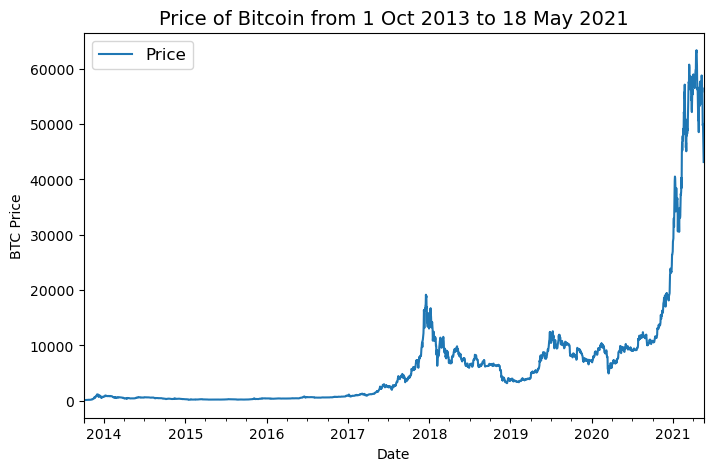

In [25]:
plot_dataframe(bitcoin_prices, "Price of Bitcoin from 1 Oct 2013 to 18 May 2021", "BTC Price")

### Train/Test Split

First, let's turn our DataFrame index and column into NumPy arrays.

In [26]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:5], prices[:3]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483]))

In [27]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

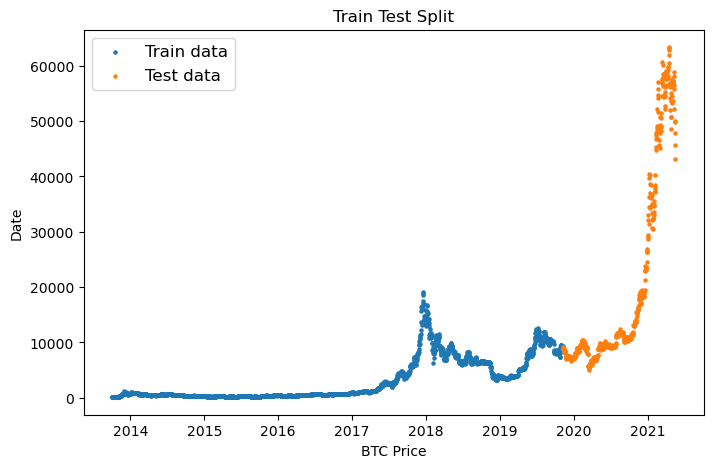

In [28]:
plot_train_vs_test(X_train, y_train, X_test, y_test, 'Train Test Split', 'Date', 'BTC Price')

We'll use the training set (past data) to train our model and evaluate its performance on the test set, which represents a simulated future.

It's important to understand that the test set is not the real future—it's a pseudofuture created from historical data. Its purpose is to give us an indication of how well our model might perform when making predictions on unseen, real future data.

By evaluating performance on this pseudofuture, we can identify issues, tune our model, and build confidence in its generalization ability—before deploying it in real-world scenarios.

<a name="3.3"></a>
### <font color='#2874a6'> <b> 3.3. Pre-processing </font> </b>

Since most models require different input data (e.g., due to different window sizes or horizons), we will perform the preprocessing immediately before building the model.

<a name="3.4"></a>
### <font color='#2874a6'> <b> 3.4. Experiments </font> </b>

We will conduct the following experiments:

| Model Number | Model Type | Horizon size | Window size |
| ----- | ----- | ----- | ----- | 
| 0 | Naïve model (baseline) | NA | NA |
| 1 | Dense model | 1 | 7 | 
| 2 | Dense model | 1 | 30 | 
| 3 | Dense model | 7 | 30 | 
| 4 | Conv1D | 1 | 7 | 
| 5 | LSTM | 1 | 7 | 
| 6 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | 


<a name="3.4.1"></a>
#### <font color='#2e86c1'> <b> 3.4.1. Model 0 (Baseline) : Naive Forecast </font> </b>

**Naive Forecast**

$$\hat{y}_{t} = y_{t-1}$$ 

In [30]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:3], naive_forecast[-3:] # View first 3 and last 3 

(array([9226.48582088, 8794.35864452, 8798.04205463]),
 array([50032.69313676, 47885.62525472, 45604.61575361]))

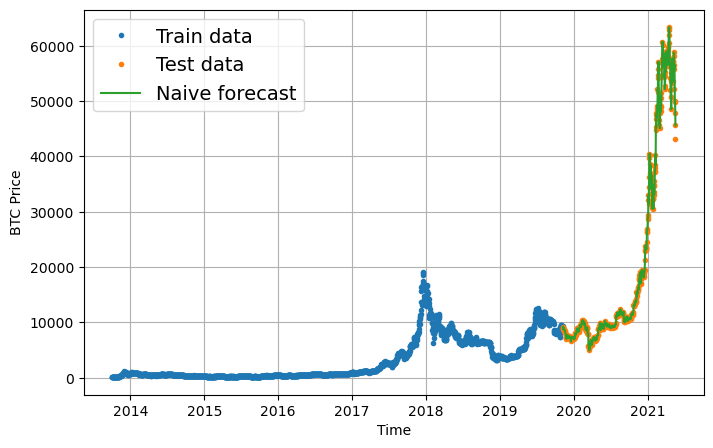

In [31]:
# Plot naive forecast
plt.figure(figsize=(8, 5))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

Let's zoom in to take a better look.

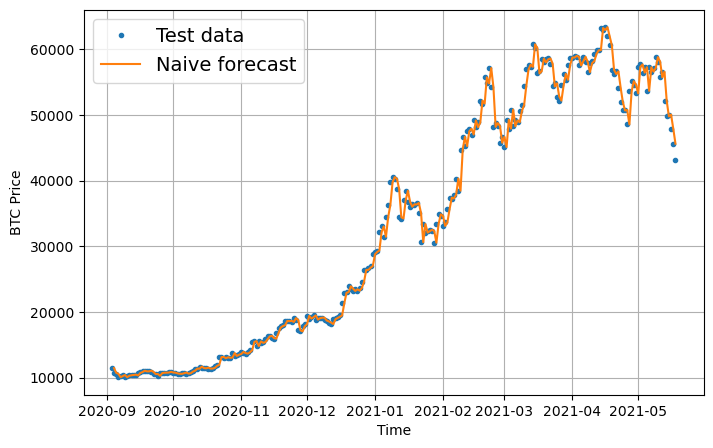

In [32]:
plt.figure(figsize=(8, 5))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

We see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

In [33]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [39]:
# Find average price of Bitcoin in test dataset
avg_price_test = tf.reduce_mean(y_test).numpy()
avg_price_test

20056.632963737226

In [38]:
relative_MAE = naive_results['mae']/avg_price_test
relative_MAE

0.02831882228868096

**Results**

- MAE (Mean Absolute Error): ~568

- Mean of y_test: ~20,057

- Relative MAE: 2.83%

**Interpretation**

An average error of $568 on a value around $20,000 indicates reasonable absolute accuracy, but since Bitcoin price fluctuates heavily, the MAE alone may be misleading:

- For low-volatility periods, this error could be large.

- For high-volatility periods, it might be small in comparison.

**Warning**

In volatile series like Bitcoin, relative metrics such as MAPE (Mean Absolute Percentage Error) or normalized RMSE often give better context.




<a name="3.4.2"></a>
#### <font color='#2e86c1'> <b> 3.4.2. Dense Model (window=7, horizon=1)</font> </b>

#### Pre-processing

In [40]:
WINDOW_SIZE = 7
HORIZON = 1

In [41]:
# windowing
full_windows, full_labels = make_windows(prices, window_size=G.WINDOW_SIZE, horizon=G.HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [42]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [43]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


In [47]:
# Train/Test Split
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116]]))

In [48]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-G.HORIZON-1]), y_train[G.WINDOW_SIZE:])

True

#### Build, compile and fit the model

In [54]:
def build_compile_model_one(name, horizon=1):
    
    model = tf.keras.Sequential([
          layers.Dense(10, activation="relu"),
          layers.Dense(horizon, activation="linear") # linear activation is the same as having no activation                        
        ], name=name)
    
    model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])
    
    return model

model_1 = build_compile_model_one("model_1_dense")    


In [55]:
# Fit model
history_1 = model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels,
            epochs=50,
            verbose=0,
            batch_size=G.BATCH_SIZE,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

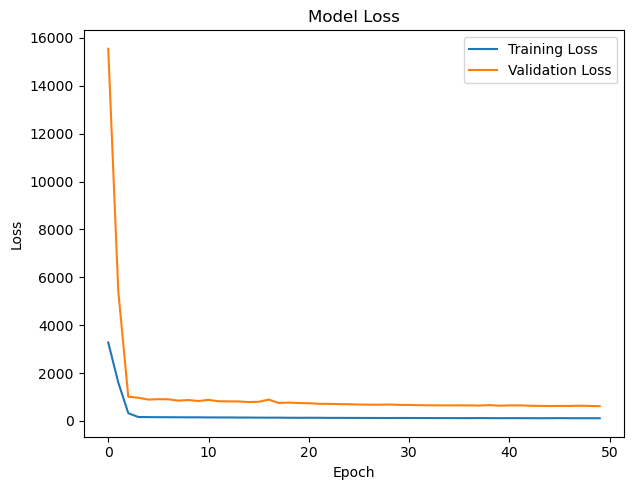

In [56]:
plot_history(history_1)

#### Load the best model


In [59]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")

#### Predictions and evaluation

In [60]:
future_forecast = make_future_forecast(model=model_1,
                                       initial_window=test_windows[0], # first test window
                                       into_future=len(test_labels),
                                       window_size=G.WINDOW_SIZE)

In [61]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=future_forecast)
model_1_results

{'mae': 7974.963,
 'mse': 89748770.0,
 'rmse': 9473.583,
 'mape': 54.333675,
 'mase': 14.009801}

#### Analysis

- MAE: 7,975
High absolute error — large misses in dollar terms.

- RMSE: 9,474 > MAE
Indicates presence of large outliers — the model sometimes makes very bad predictions.

- MAPE: 54.3%
On average, predictions are off by over half the true value — very poor accuracy.

- MASE: 14.0
The model performs much worse than a naive forecast (e.g., repeating last value).

This model is failing badly.

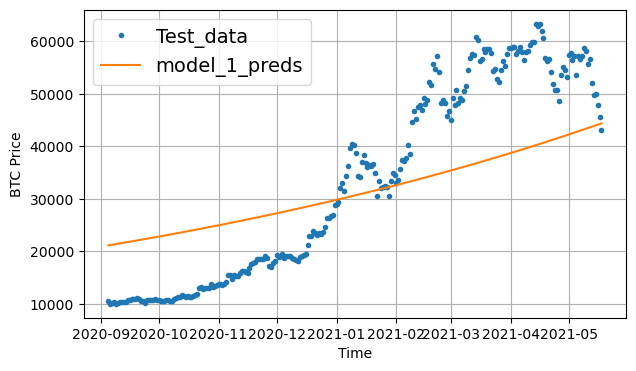

In [62]:
plot_comparisson(X_test[-len(test_windows):], test_labels[:, 0], future_forecast, 'model_1_preds', 
                 figsize=(7, 4))

<a name="3.4.3"></a>
#### <font color='#2e86c1'> <b> 3.4.3. Dense Model (window=30, horizon=1)</font> </b>

Now, we will try a larger window size. Because of that, we need to adjust the data for the new model.

#### Pre-processing

In [63]:
# hyperparameters
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [64]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [65]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
train_windows.shape, train_labels.shape, test_windows.shape, test_labels.shape

((2205, 30), (2205, 1), (552, 30), (552, 1))

#### Build, compile and fit the model

In [66]:
def build_compile_model_2(name, horizon):
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(horizon)
    ], name=name)
    
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam())
    
    return model

model_2 = build_compile_model_2('model_2_dense', HORIZON)

In [67]:
# fit
history_2 = model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

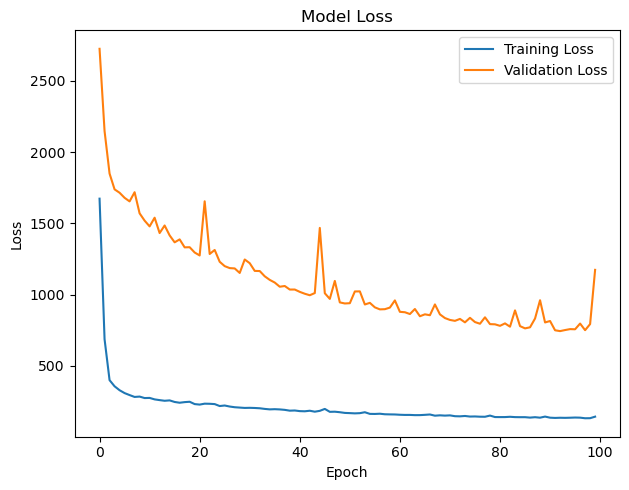

In [68]:
plot_history(history_2)

#### Load the best model

In [69]:
# Load in saved best performing model_2 and evaluate on test data
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")

#### Predictions and evaluation

{'mae': 10109.13, 'mse': 306134430.0, 'rmse': 17496.697, 'mape': 34.22993, 'mase': 17.670856}


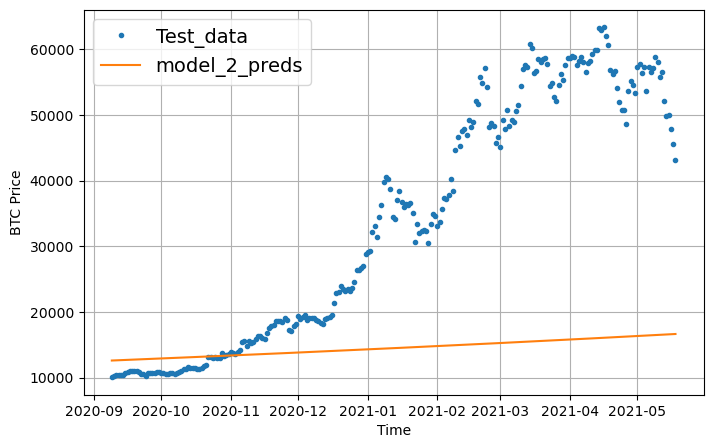

In [70]:
future_forecast_2 = make_future_forecast(model=model_2,
                                       initial_window=test_windows[0],
                                       into_future=len(test_labels),
                                       window_size=WINDOW_SIZE)
                                       
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=future_forecast_2)

print(model_2_results)

plot_comparisson(X_test[-len(test_windows):], test_labels[:, 0], future_forecast_2, 
                 'model_2_preds', figsize=(8, 5))

#### Analysis

| Metric   | Value  | Interpretation                                                                      |
| -------- | ------ | ----------------------------------------------------------------------------------- |
| **MAE**  | 10,109 | Very high average error in dollars — worse than before.                             |
| **RMSE** | 17,497 | Much higher than MAE → indicates **severe outliers**.                               |
| **MAPE** | 34.2%  | Predictions are off by **over a third** on average — poor accuracy.                 |
| **MASE** | 17.67  | The model is performing **\~17× worse than a naive forecast** — a critical failure. |

The model’s performance has significantly degraded. Increasing the window size did not help.


<a name="3.4.4"></a>
#### <font color='#2e86c1'> <b> 3.4.4. Dense Model (window=30, horizon=7)</font> </b>

#### Pre-processing

In [72]:
HORIZON = 7
WINDOW_SIZE = 30

In [94]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [74]:
full_windows[-1], full_labels[-1], full_windows[-1].shape, full_labels[-1].shape

(array([59822.90167743, 59853.19724227, 63223.88439079, 62926.5571759 ,
        63346.78903511, 61965.7825981 , 60574.44472823, 56850.83016569,
        56224.10158771, 56608.76974839, 54144.42747606, 51965.05955941,
        50669.14438218, 50733.76950364, 48542.95220298, 53558.70784462,
        55123.86198142, 54591.51532554, 53260.29534115, 57302.64642408,
        57677.9752219 , 56427.04312502, 57255.30683756, 53658.84312082,
        57252.7021845 , 56583.84987917, 57107.12067189, 58788.20967893,
        58102.19142623, 55715.54665129]),
 array([56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361, 43144.47129086]),
 (30,),
 (7,))

In [95]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

#### Build, compile and fit the model

In [76]:
def build_compile_model_3(name, horizon):
    
    model = tf.keras.Sequential([
      layers.Dense(256, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(horizon)
    ], name=name)

    model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())
    
    return model


model_3 = build_compile_model_3('model_3_dense', HORIZON)

In [77]:
history_3 = model_3.fit(train_windows,
            train_labels,
            batch_size=32,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

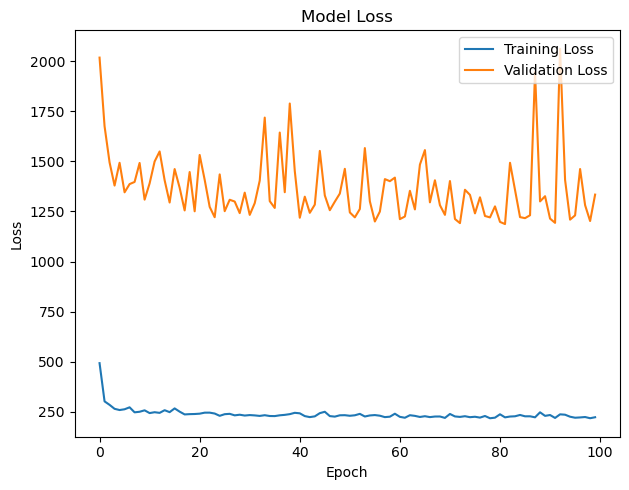

In [78]:
plot_history(history_3)

#### Load the best model

In [79]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")

#### Predictions and evaluation

In [87]:
test_labels.shape

(551, 7)

In [91]:
def make_future_forecast_generalized(model, initial_window, into_future, horizon, window_size=32, verbose=False) -> np.ndarray:
    """
    Generate future predictions using a sliding window for models that output multiple steps at once.
    Returns predictions as a 2D array of shape (num_forecasts, horizon).
    """
    future_forecast = []
    last_window = initial_window.copy()
    
    steps = int(np.ceil(into_future / horizon))

    for _ in range(steps):
        future_pred = model.predict(tf.expand_dims(last_window, axis=0), verbose=0)  # shape: (1, horizon)
        future_pred = tf.squeeze(future_pred).numpy()  # shape: (horizon,)
        
        if verbose:
            print(f"Predicting on: \n{last_window} -> Prediction: {future_pred}\n")

        future_forecast.append(future_pred)  # Append as row, not flattened

        # Update window
        last_window = np.append(last_window, future_pred)[-window_size:]

    # Return as (num_steps, horizon), trim excess if needed
    forecast_array = np.array(future_forecast)  # shape: (steps, horizon)
    
    # If exact match is needed with test_labels shape:
    total_needed = (into_future // horizon)
    return forecast_array[:total_needed]


In [98]:
#into_future = len(test_labels) * horizon
future_forecast_3 = make_future_forecast_generalized(model=model_3,
                                       initial_window=test_windows[0],
                                       into_future=len(test_labels)*HORIZON, # NEW
                                       horizon=HORIZON,            
                                       window_size=WINDOW_SIZE)
                                       


In [99]:
future_forecast_3.shape

(551, 7)

In [104]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=future_forecast_3)

print(model_3_results)

#plot_comparisson(X_test[-len(test_windows):], test_labels[:, 0], future_forecast_3, 
#                 'model_2_preds', figsize=(8, 5))

{'mae': 12326470000.0, 'mse': 1.2816057e+21, 'rmse': 35799520000.0, 'mape': 23569438.0, 'mase': 21934260.0}
